# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

ts = pd.read_csv("data/daily_restaurant_sales.csv")
ts

,x
0,88
1,84
2,85
3,85
4,84
...,...
95,222
96,228
97,226
98,222


<Axes: >

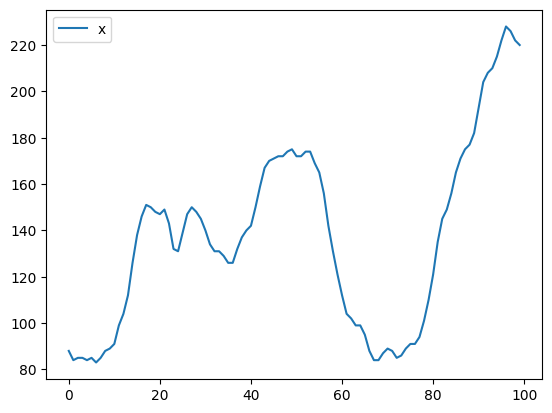

In [2]:
ts.plot()

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.464239717203368
p-value: 0.12441935447109481
Critial Values:
   1%, -3.5003788874873405
Critial Values:
   5%, -2.8921519665075235
Critial Values:
   10%, -2.5830997960069446


The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

In [4]:
d = 0
p_value = adfuller(ts, autolag='AIC')[1]
series = ts.copy()

#Recherche 
while p_value > 0.05 :
    series = series.diff()
    series.dropna(inplace=True)
    d += 1
    p_value = adfuller(series, autolag='AIC')[1]
    print(p_value)
    if d > 20 : break

    
print(f"The minimum order of differencing that we need for stationarity is {d}")

0.07026846015272718
2.8434287555471576e-17
The minimum order of differencing that we need for stationarity is 2


We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

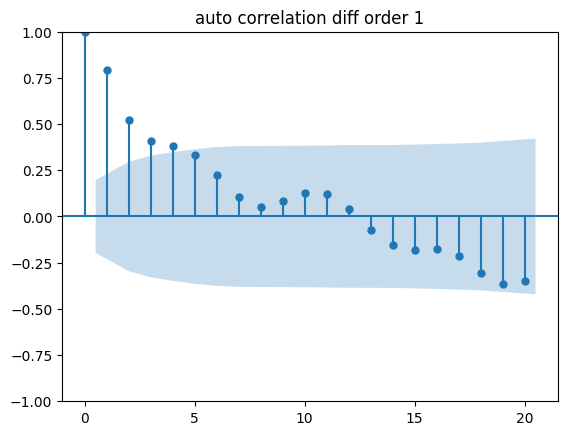

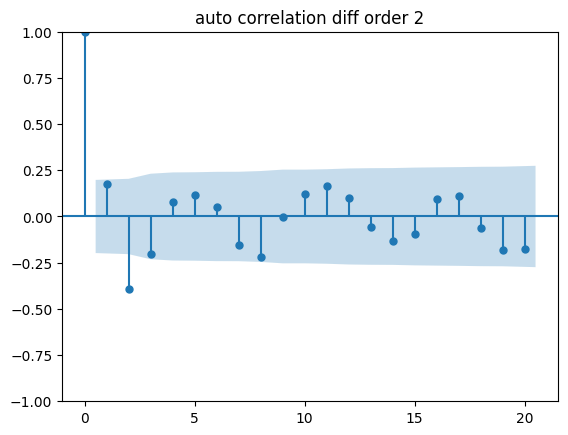

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts.diff().dropna(), title="auto correlation diff order 1");
plot_acf(ts.diff().dropna().diff().dropna(), title="auto correlation diff order 2");

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [6]:
y_diff = ts.diff().dropna()
d = 1

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

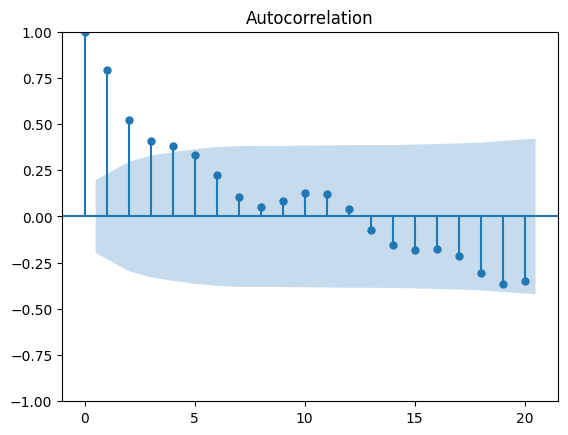

In [7]:
plot_acf(y_diff);

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

C:\Users\utilisateur\jupyter\Brief_ Les Sables Du Temps\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


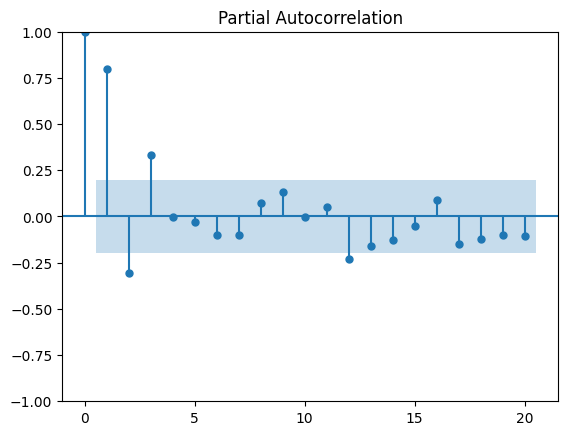

In [8]:
plot_pacf(y_diff);

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [9]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 3, 1, 2
model = ARIMA(ts, order=(p, d, q))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                  100
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -251.959
Date:                Wed, 08 Mar 2023   AIC                            515.918
Time:                        17:11:14   BIC                            531.489
Sample:                             0   HQIC                           522.218
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0711      0.470      2.279      0.023       0.150       1.992
ar.L2         -0.6013      0.367     -1.636      0.102      -1.322       0.119
ar.L3          0.3364      0.184      1.829      0.067      -0.024       0.697
ma.L1          0.0879      0.467      0.188      0.851      -0.827       1.003
ma.L2          0.0300      0.344      0.087      0.930      -0.643       0.703
sigma2         9.3556      1.424      6.571      0.000       6.565      12.146
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.90   Prob(JB):                         0.91
Heteroskedasticity (H):               0.54   Skew:                            -0.11
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

In [10]:
p, d, q = 1, 1, 1
model = ARIMA(ts,order=(p, d, q))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Wed, 08 Mar 2023   AIC                            514.300
Time:                        17:11:17   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.000       7.040      12.547
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.86   Prob(JB):                         0.94
Heteroskedasticity (H):               0.63   Skew:                            -0.08
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

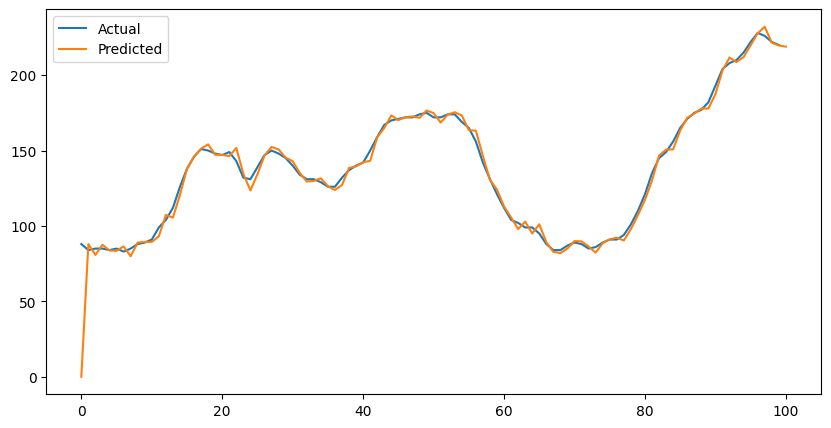

In [11]:
def plot_predict(model, ts, dynamic=False, start=0, end= len(ts)):    
    predictions = model.predict(dynamic=dynamic, start=start, end=end)    
    plt.figure(figsize=(10,5))
    plt.plot(ts, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend(loc='upper left')
    plt.show()
    
plot_predict(model, ts)

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

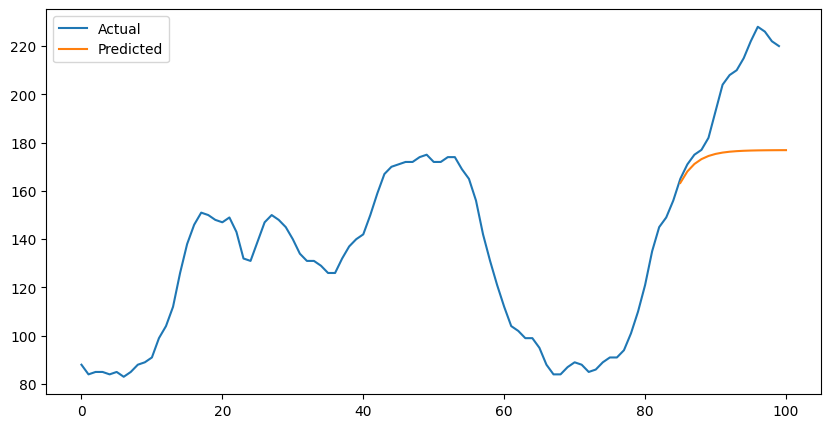

In [12]:
plot_predict(model, ts, dynamic=True, start=85)

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [13]:
# Split data into training and test sets
train = ts.loc[:85]
test = ts.loc[85:]
test

,x
85,165
86,171
87,175
88,177
89,182
90,193
91,204
92,208
93,210
94,215


In [14]:
p, d, q = 1, 1, 1
model = ARIMA(train,order=(p, d, q))
model_fit = model.fit()

👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [15]:
# FORECASTING AND CONFIDENCE INTERVALS

# Generating Forecast object
forecasts = model_fit.get_forecast(len(test.index))
# Generating confidence intervals
forecasts_df = forecasts.conf_int(alpha = 0.05)  # Confidence Interval of 95%
# Actual predictions
forecasts_df["Predictions"] =  model_fit.forecast(steps=len(test))

# Displaying first 5 rows of the forecasts_df
print(forecasts_df)

        lower x     upper x  Predictions
86   165.652574  178.064444   171.858509
87   161.671044  191.169298   176.420171
88   156.065882  202.842469   179.454176
89   149.821380  213.122864   181.472122
90   143.431454  222.197101   182.814277
91   137.144977  230.268939   183.706958
92   131.081433  237.519944   184.300689
93   125.290544  244.100625   184.695585
94   119.784587  250.131881   184.958234
95   114.556335  255.709513   185.132924
96   109.589108  260.909117   185.249112
97   104.862363  265.790418   185.326390
98   100.354750  270.400827   185.377789
99    96.045701  274.778248   185.411974
100   91.916189  278.953234   185.434711


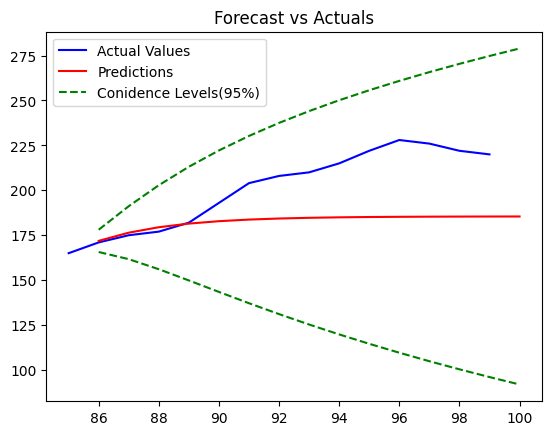

In [16]:
# Actual values of the S&P 500 returns in the test set
plt.plot(test, color = "blue", label = "Actual Values")

# Predictions from the model and confidence intervals
plt.plot(forecasts_df["Predictions"], color = "red", label = "Predictions")
plt.plot(forecasts_df["upper x"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(forecasts_df["lower x"], color = "green", linestyle = "--")

# Title of the plot
plt.title('Forecast vs Actuals')
# Display the labels
plt.legend()
# Display the plot
plt.show()

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

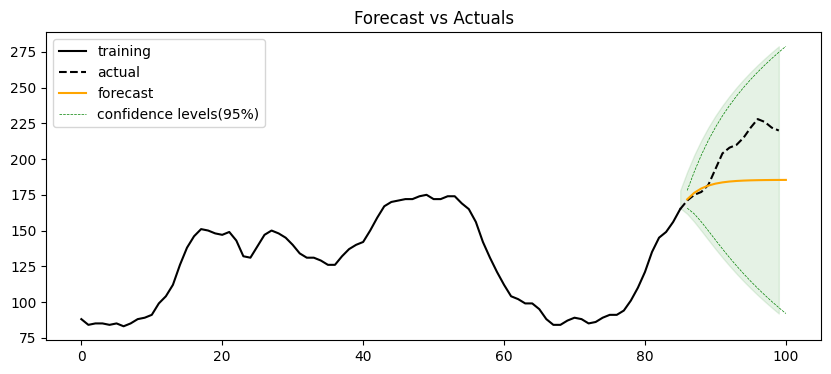

In [17]:
def plot_forecast(fc, train, test, upper, lower ):    
    plt.figure(figsize=(10,4))
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc, label='forecast', color='orange')
    plt.plot(upper, color = "green", linestyle = "--", label = "confidence levels(95%)", lw=0.5)
    plt.plot(lower, color = "green", linestyle = "--", lw=0.5)
    plt.fill_between(test.index, upper, lower, color='green', alpha=.1)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left')
    plt.show()

plot_forecast(forecasts_df["Predictions"], 
              train, 
              test, 
              forecasts_df["upper x"], 
              forecasts_df["lower x"])

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

In [18]:
residuals = model_fit.resid
residuals

0     88.000000
1     -4.002426
2      4.238919
3     -2.443556
4      0.158921
        ...    
81     4.885931
82    -1.709957
83    -1.811707
84     5.228898
85     1.777454
Length: 86, dtype: float64

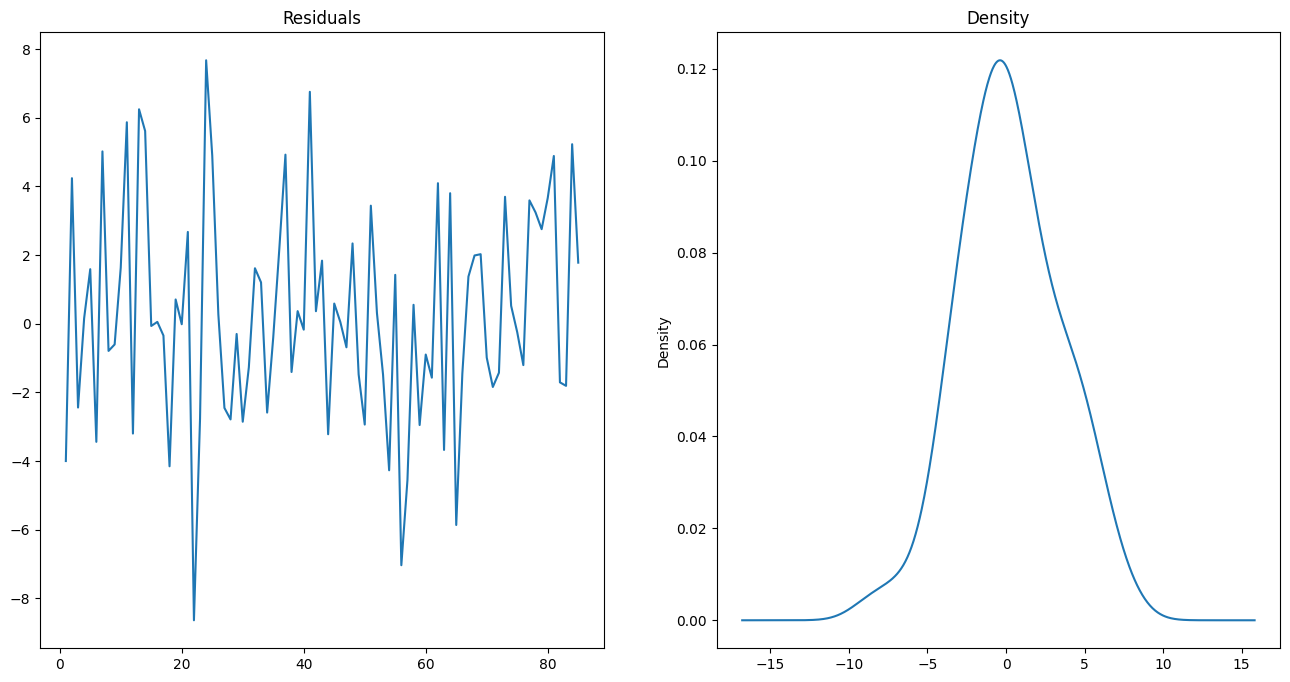

In [19]:
# Plot residual errors
fig, ax = plt.subplots(1,2, figsize=(16,8))
residuals[1:].plot(title="Residuals", ax=ax[0])
residuals[1:].plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [20]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [21]:
forecast_accuracy(forecasts_df["Predictions"], test['x'])

{'mape': 0.10086036953089175,
 'me': -21.201506461777882,
 'mae': 21.8776286988821,
 'mpe': -0.0970030577313697,
 'rmse': 26.736506144215607,
 'acf1': nan,
 'corr': 0.8570513595842715,
 'minmax': 0.09958988906654254}

## 4 Grid Search
#link to understand Grid Search https://www.lovelyanalytics.com/2017/10/16/grid-search/

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [22]:
import pmdarima as pm
for d in range(1,3):
    model = pm.auto_arima(ts, 
                          start_p=0, start_q=0, 
                          max_p=4, max_q=5,
                          seasonal=False, 
                          trace=True, suppress_warnings=True, error_action='ignore',
                          d=d)    

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=627.619, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=530.856, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=548.164, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=630.995, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=523.315, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=513.666, Time=0.06 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=515.581, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=515.593, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=517.580, Time=0.12 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=514.252, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=511.995, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=522.179, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=513.931, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=513.939, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=516.2

## Cross-validate performance of your model

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [23]:
possible_best_hyperparameters = [(3,1,0),(2,2,0)]

In [24]:
from sklearn.model_selection import TimeSeriesSplit


def set_arima(train, hp ):
    model = ARIMA(train,order=hp)
    return model.fit()

def get_scores_mean(data):    
    tmp = pd.DataFrame(data)
    means = tmp.mean()
    return means

def launch_cv(hyperparameters, splits = 5):    
    cv = TimeSeriesSplit(n_splits=splits)
    scores_list = []
    for i, (train_index, test_index) in enumerate(cv.split(ts)):        
        # Split the data into training and test sets
        train, test = ts.iloc[train_index], ts.iloc[test_index]
        model_fit = set_arima(train, hyperparameters)        
        # Predict and get scoress
        predictions = model_fit.forecast(len(test.index))
        scores = forecast_accuracy(predictions, test['x'])
        scores_list.append(scores)

    scores_means = get_scores_mean(scores_list)
    print(f"Hyperparameters (p,d,q): {hyperparameters}")
    print(scores_means, "\n")

In [25]:
for pbh in possible_best_hyperparameters :
    launch_cv(pbh)

Hyperparameters (p,d,q): (3, 1, 0)
mape       0.231820
me        -8.853764
mae       31.180192
mpe       -0.018949
rmse      36.847799
acf1       0.803128
corr      -0.206301
minmax     0.190063
dtype: float64 

Hyperparameters (p,d,q): (2, 2, 0)
mape       0.265770
me        -8.538176
mae       32.898918
mpe       -0.036450
rmse      39.766338
acf1       0.759088
corr      -0.243562
minmax     0.216678
dtype: float64 



**I think best parameters for ARIMA model are p=3, d=1 and q=0**